# YOLO Vignette
**Contributors: Bennett Bishop, Joseph Zaki, Luke Dillon, Benjamin Drabeck, Samantha Su**

Github Repo: https://github.com/Capstone-24-25/vignette-YOLO/tree/main


## YOLO Explaination

### What is YOLO?

YOLO, which stands for "You Only Look Once," is a real-time object detection system. Unlike traditional object detection methods that involve separate region proposal and classification stages, YOLO frames object detection as a single regression problem, straight from image pixels to bounding box coordinates and class probabilities. This allows YOLO to detect objects in images and videos quickkly, making it suitable for applications requiring real-time processing, such as autonomous driving, security surveillance, and augmented reality.

### How does YOLO work?

YOLO works by dividing the input image into a grid of cells, each of which predicts a fixed number of bounding boxes and confidence scores. These confidence scores reflect the likelihood that the predicted bounding box contains an object and the accuracy of the box itself. For each bounding box, YOLO also predicts the probability distribution over the various classes of objects. By merging these predictions, YOLO is capable of identifying multiple objects within an image efficiently and accurately. The use of a single neural network to process the entire image, rather than relying on multiple stages, is what gives YOLO its speed and performance advantages.

## Preprocessing Steps



### Importing libraries

In [ ]:
# Ultralytitcs 8.3.43 has errors with YOLO, so we are using 8.3.40
from ultralytics import YOLO
import csv
import os
import numpy as np
import shutil
from glob import glob
from tqdm import tqdm
from random import shuffle, seed
import matplotlib.pyplot as plt
import cv2

### Preprocessing

This code prepares a dataset for training, validation, and testing in YOLO using the Ultralytics library. It begins by identifying the 74 classes of military aircraft by reading folder names in a specified parent directory (crop). A big challenge with YOLO is ensuring all of our data is organized in the correct format that YOLO can process.

The csv_to_txt function is important in converting annotation data from .csv files into YOLO's required .txt format. Each .txt file corresponds to a .jpg image and contains annotation details in YOLO format: class number, normalized center coordinates (x_center, y_center), and normalized dimensions (width, height). This function processes bounding box coordinates for all objects in the dataset, ensuring compatibility with YOLO.

The train_test_valid function splits the dataset into training, testing, and validation subsets based on specified ratios. It pairs .jpg files with their corresponding annotation files, shuffles them using a random seed for reproducibility, and allocates them to the respective splits.

Finally, the data_copy function organizes the dataset in the structure expected by Ultralytics YOLO, separating images into one directory and annotations into another. It copies the image files and generates the corresponding .txt annotations in the appropriate directories. Together, these functions automate dataset preprocessing, ensuring the data is correctly formatted and structured for YOLO training and evaluation.

In [ ]:
classes = np.array(["A10", "A400M", "AG600", "AH64", "An124", "An22", "An225", "An72", "AV8B", "B1", "B2", "B21", "B52", "Be200", "C130", "C17", "C2", "C390", "C5", "CH47", "CL415", "E2", "E7", "EF2000", "F117", "F14", "F15", "F16", "F18", "F22", "F35", "F4", "H6", "J10", "J20", "JAS39", "JF17", "JH7", "Ka27", "Ka52", "KC135", "KF21", "KJ600", "Mi24", "Mi26", "Mi28", "Mig29", "Mig31", "Mirage2000", "MQ9", "P3", "Rafale", "RQ4", "SR71", "Su24", "Su25", "Su34", "Su57", "TB001", "TB2", "Tornado", "Tu160", "Tu22M", "Tu95", "U2", "UH60", "US2", "V22", "Vulcan", "WZ7", "XB70", "Y20", "YF23", "Z19"])

def csv_to_txt(csv_path, output_path):
    """
	Ultralytics requires .txt files to be paired with the .jpg files
	.txt files contain annotations. This function extracts those 
    annotations from the .csv files and converts them into .txt files
	"""
    with open(csv_path, 'r') as csv_file:
        reader = csv.DictReader(csv_file)
    
        for row in reader:
            filename = row['filename']
            width = float(row['width'])
            height = float(row['height'])
            obj_num = np.where(classes == row['class'])[0][0]
            xmin = float(row['xmin'])
            ymin = float(row['ymin'])
            xmax = float(row['xmax'])
            ymax = float(row['ymax'])

			# YOLO format is class x_center y_center norm_width norm_heigh
            x_center = ((xmin + xmax) / (2 * width))
            y_center = ((ymin + ymax) / (2 * height))
            norm_width = (xmax - xmin) / width
            norm_height = (ymax - ymin) / height

            yolo_format_line = f'{obj_num} {x_center} {y_center} {norm_width} {norm_height}\n'

            txt_filename = os.path.join(output_path, f'{filename}.txt')

            with open(txt_filename, 'a') as txt_file:
                txt_file.write(yolo_format_line)

def train_test_valid(jpgs, csvs, train_ratio, test_ratio, rand_seed=1492):
    """
    Separates dataset into train/test/validation
    Since every jpg file has a corresponding annotations, we
    just have to match them and then shuffle the matched set
    """
    jpgs.sort()
    csvs.sort()
    
    joined_paths = list(zip(jpg_paths, csv_paths))

    seed(rand_seed)
    shuffle(joined_paths)

    train_end = int(len(joined_paths) * train_ratio)
    test_end = train_end + int(len(joined_paths) * test_ratio)

    train_paths = joined_paths[:train_end]
    test_paths = joined_paths[train_end:test_end]
    valid_paths = joined_paths[test_end:]

    return train_paths, test_paths, valid_paths

def data_copy(path_list, target_img_dir, target_label_dir):
    """
    Copies data into ultralytic's format: a path for labels, and a path for images
    """    
    for paths in tqdm(path_list):
        jpg = paths[0]
        labels = paths[1]

        csv_to_txt(labels, target_label_dir)
        shutil.copy(jpg, target_img_dir)

We then need to aggregate all image (.jpg) and annotation (.csv) file paths from the dataset directory using glob. Next, we need to create the required directory structure for YOLO, including separate subdirectories for images and labels under training, testing, and validation datasets. Using the train_test_valid() function, the dataset is split into 80% for training, 10% for testing, and 10% for validation. The data_copy() function is then called to copy the respective image and annotation files into their designated directories, converting .csv annotations to YOLO-compatible .txt files in the process. Finally, the code generates a data.yaml file that specifies the dataset paths, the number of classes (nc), and the class names. This YAML file is essential for YOLO to correctly locate the dataset and understand its structure during training or evaluation.

In [5]:
# Aggregate all the jpg and csv paths in our data
jpg_paths = glob("/kaggle/input/militaryaircraftdetectiondataset/dataset/*.jpg")
csv_paths = glob("/kaggle/input/militaryaircraftdetectiondataset/dataset/*.csv")

# Make directories that the data will be stored in
os.makedirs("/kaggle/working/ultralytics/data/train/images/", exist_ok=True)
os.makedirs("/kaggle/working/ultralytics/data/train/labels/", exist_ok=True)
os.makedirs("/kaggle/working/ultralytics/data/test/images/", exist_ok=True)
os.makedirs("/kaggle/working/ultralytics/data/test/labels/", exist_ok=True)
os.makedirs("/kaggle/working/ultralytics/data/valid/images", exist_ok=True)
os.makedirs("/kaggle/working/ultralytics/data/valid/labels", exist_ok=True)

# Train/test/validation split 80%-10%-10% respectively
train_paths, test_paths, valid_paths = train_test_valid(jpg_paths, csv_paths, 0.8, 0.1)

# Copy data to respective paths
data_copy(test_paths,"/kaggle/working/ultralytics/data/test/images/", "/kaggle/working/ultralytics/data/test/labels/")
data_copy(valid_paths,"/kaggle/working/ultralytics/data/valid/images/", "/kaggle/working/ultralytics/data/valid/labels/")
data_copy(train_paths,"/kaggle/working/ultralytics/data/train/images/", "/kaggle/working/ultralytics/data/train/labels/")

# YOLO requires .yaml file that specifies the directories of the data

# The paths in this file may need to be modified for ultralytics to be able to recognize them
with open("/kaggle/working/ultralytics/data.yaml", 'w') as file:
    class_names = ', '.join(classes)
    data_path = "/kaggle/working/ultralytics/data/"
    train_path = "train/"
    test_path = "test/"
    valid_path = "valid/"
    yaml_str = f'path: {data_path}\n'\
               f'train: {train_path}\n'\
               f'val: {valid_path}\n'\
               f'nc: {len(classes)}\n'\
               f'names: [{class_names}]'
    file.write(yaml_str)

100%|██████████| 14804/14804 [05:41<00:00, 43.31it/s]


## Training the model
Since actually training a YOLO model is a time-intensive task, we have included below the code necessary to train the model on Kaggle. For information on training a YOLO model using a high performance computing cluster, see the section titled "Larger Models and Training with High Performance Computing Resources".

For evaluation and demonstration, we will use the YOLO11m model we trained on our dataset.

```python
model = YOLO("yolo11m.pt")
results = model.train(data="/kaggle/working/ultralytics/data.yaml", epochs=50, imgsz=640, batch=-1)
```

The results variable stores various validation metrics about our model with the best performance.
These metrics can also be found under `runs/detect/train`.
The weights for the best performing and final iterations can be found under `runs/detect/train/weights`.

### Loading Trained Model & Exploring Metrics

We can validate our model and explore metrics using YOLO's built in metric library. 

The first block of code dynamically generates a data.yaml file, which specifies the dataset structure, including paths to the training, validation, and testing data, as well as the number of classes (nc) and their names. This YAML configuration file is essential for YOLO to understand the dataset organization and perform operations like training or validation.

The second part of the code imports the YOLO library and loads a pre-trained model with over 20 million parameters from the specified file path. The trained_model.val() function validates the model using the dataset defined in data.yaml. During this process, YOLO calculates key performance metrics, such as precision, recall, and mean Average Precision (mAP), allowing us to evaluate the model's effectiveness on the dataset.

In [ ]:
# Validate our model with example dataset
with open("/kaggle/working/ultralytics/data.yaml", 'w') as file:
    class_names = ', '.join(classes)
    data_path = "/kaggle/working/ultralytics/data/"
    train_path = "train/"
    test_path = "test/"
    valid_path = "valid/"
    yaml_str = f'path: {data_path}\n'\
               f'train: {train_path}\n'\
               f'val: {test_path}\n'\
               f'nc: {len(classes)}\n'\
               f'names: [{class_names}]'
    file.write(yaml_str)

# Load trained model 
trained_model = YOLO(model = "/kaggle/input/yolov11m-best.pt/other/default/1/yolov11m-best.pt", task = "detection")
results = trained_model.val(data="/kaggle/working/ultralytics/data.yaml")

Ultralytics 8.3.40 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m summary (fused): 303 layers, 20,087,086 parameters, 0 gradients, 68.0 GFLOPs


val: Scanning /kaggle/working/ultralytics/data/test/labels.cache... 1850 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1850/1850 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 116/116 [00:28<00:00,  4.02it/s]


                   all       1850       3252      0.772      0.659      0.755      0.688
                 CL415         30         41      0.976      0.732      0.846      0.746
                 JAS39         28         42      0.675      0.762      0.755      0.674
                    C5         29         32      0.682      0.671      0.799      0.709
                    E2         36         45      0.743      0.667      0.776      0.699
                 Mig31         33         65      0.848      0.631      0.827      0.715
                   RQ4         23         28      0.629      0.726      0.766       0.69
            Mirage2000         29         60      0.805       0.65      0.746      0.638
                    B2         47         59      0.821      0.776      0.842      0.768
                   US2         61         67       0.89      0.843      0.913      0.845
                    H6         19         35      0.888      0.571      0.858      0.752
                    P

The YOLO model's validation metrics showcase its performance in detecting 74 classes of military aircraft. Overall, the model achieves a mean Average Precision (mAP@0.5) of 75.5% and a mAP@0.5-0.95 of 68.8%. The high precision values for certain classes like "CL415" (97.6%), "RQ4" (88.8%), and "AH64" (91.4%) indicate the model excels at identifying specific aircraft with confidence. However, it struggles with others, such as "KF21" and "WZ7," both of which have relatively low recall rates, suggesting potential difficulty in consistently identifying these aircraft in diverse scenarios. The disparity in performance across classes might stem from an imbalanced dataset or the complexity of distinguishing features in some classes. Additionally, the model's inference speed of 47.8 ms per image highlights its efficiency, making it suitable for real-time applications.

### Predictions/Testing
We can test the model to see if it labels the example data correctly. We do this by using the predict function on a random image and then plotting the saved predicion to visualize our bounding box.The trained_model.predict() function takes an image as input and generates predictions, saving the output (including bounding boxes) to a specified directory.


image 1/1 /kaggle/working/ultralytics/data/valid/images/003df4fc3d3cb3aa32f709c92b1463db.jpg: 448x640 1 P3, 14.1ms
Speed: 4.0ms preprocess, 14.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict


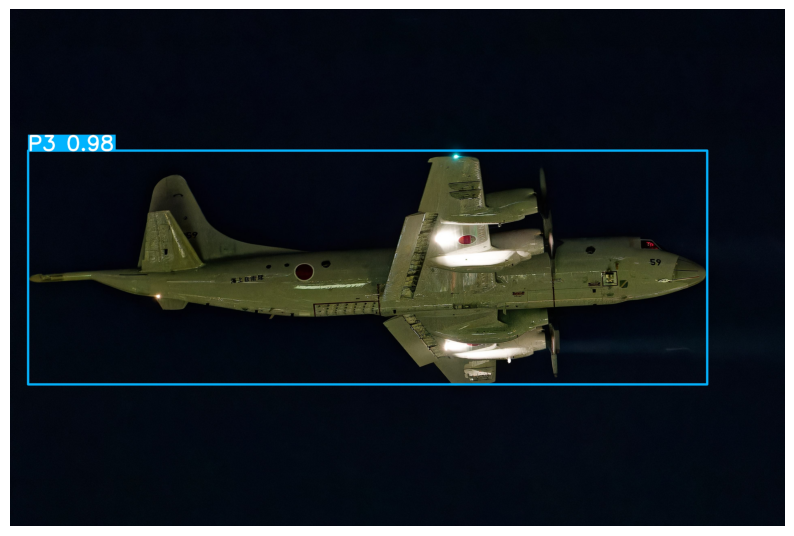

In [ ]:
image_path = "/kaggle/working/ultralytics/data/valid/images/003df4fc3d3cb3aa32f709c92b1463db.jpg"

# Make predictions
predictions = trained_model.predict(source=image_path, save=True)

# Path to the saved image
image_with_boxes_path = "runs/detect/predict/003df4fc3d3cb3aa32f709c92b1463db.jpg"

# Load the image
image = cv2.imread(image_with_boxes_path)

# Convert BGR (OpenCV default) to RGB for proper display
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")  # Turn off axis
plt.show()

In this image, the YOLO model successfully detects a single aircraft, identified as a "P3," with a high confidence score of 98%. We can repeat the process again to show multiple object predictions in a single image.


image 1/1 /kaggle/working/ultralytics/data/valid/images/0dc5de4ad1e97c2a993c75617c6b51fa.jpg: 480x640 1 E2, 10 F18s, 1 B52, 1 F15, 49.7ms
Speed: 3.5ms preprocess, 49.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict


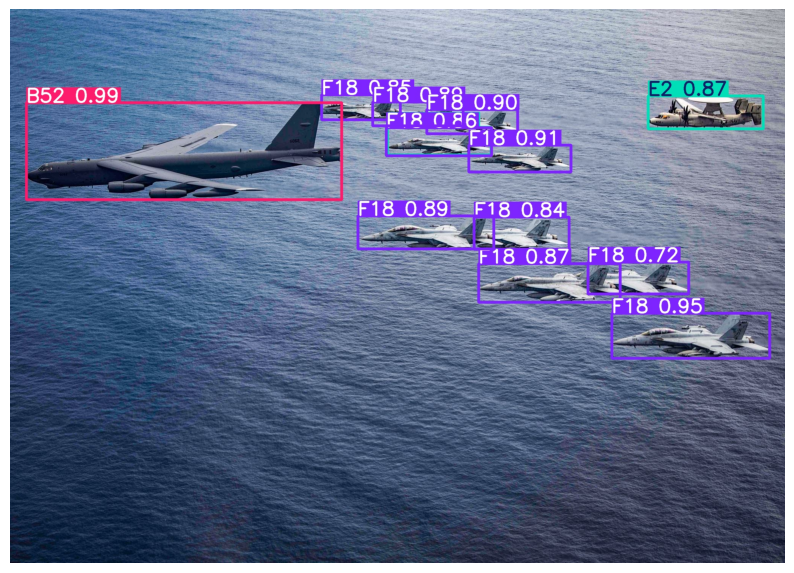

In [14]:
image_path = "/kaggle/working/ultralytics/data/valid/images/0dc5de4ad1e97c2a993c75617c6b51fa.jpg"

# Make predictions
predictions = trained_model.predict(source=image_path, save=True)

# Path to the saved image
image_with_boxes_path = "runs/detect/predict/0dc5de4ad1e97c2a993c75617c6b51fa.jpg"

# Load the image
image = cv2.imread(image_with_boxes_path)

# Convert BGR (OpenCV default) to RGB for proper display
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")  # Turn off axis
plt.show()

The YOLO model effectively detects multiple military aircraft in this image, identifying a "B52" bomber with a confidence of 99% and multiple "F18" fighter jets with confidence scores ranging from 72% to 95%. Additionally, it detects an "E2" aircraft with 87% confidence. The bounding boxes are well-aligned with the aircraft, indicating strong spatial accuracy in object localization. The variation in confidence scores among the "F18" detections could reflect differences in perspective, size, or overlap. Next, we will choose a more difficult image for YOLO to detect.


image 1/1 /kaggle/working/ultralytics/data/valid/images/06c9057baed2a5903ca870c6b72e055d.jpg: 448x640 1 F35, 15.0ms
Speed: 2.8ms preprocess, 15.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict


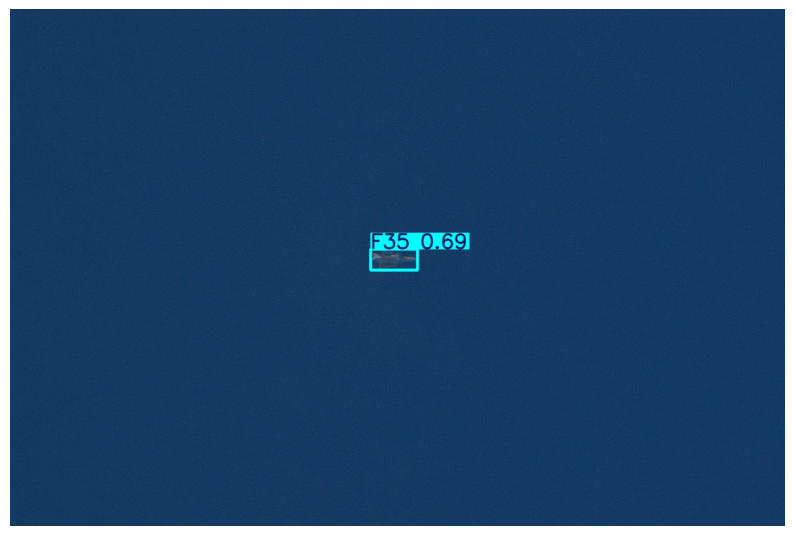

In [15]:
image_path = "/kaggle/working/ultralytics/data/valid/images/06c9057baed2a5903ca870c6b72e055d.jpg"

# Make predictions
predictions = trained_model.predict(source=image_path, save=True)

# Path to the saved image
image_with_boxes_path = "runs/detect/predict/06c9057baed2a5903ca870c6b72e055d.jpg"

# Load the image
image = cv2.imread(image_with_boxes_path)

# Convert BGR (OpenCV default) to RGB for proper display
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")  # Turn off axis
plt.show()

In this image, the YOLO model detects an "F35" aircraft with a confidence score of 69%. The detection appears to be on a relatively small object against a large, uniform background, which may have made it more challenging for the model to confidently identify the aircraft. The lower confidence score compared to other examples suggests room for improvement in handling small-scale objects or objects at a distance. The bounding box placement seems accurate, indicating the model can still localize the object effectively despite the challenging context. Further training with more samples of distant or small aircraft could help improve performance.

## Larger Models and Training with High Performance Computing Resources

A significant portion of this project was dedicated to finding suitable resources for the training of our YOLO model. Throughout this paper we have reported on the YOLO 11m (medium) model which is one of [five sizes](https://docs.ultralytics.com/models/yolo11/#performance-metrics) of the YOLO 11 model provided by ultralytics. We were able to train the YOLO 11m model on Kaggle, however we also aimed to train a larger model, the YOLO 11x which has 56.9 million parameters as compared to the YOLO 11m's 20.1 million. The larger YOLO 11x model targets better performance at the cost of speed due to its size, potentially making it less desireable for real-time use cases.

Due to the size of the model, training it with Kaggle's freely available resources would not be practical. In order to address this issue we used [UCSB's California NanoSystems Institute Center for Scientific Computing's](https://csc.cnsi.ucsb.edu/) high performance computing clusters. We were able to train the YOLO 11x model for 50 epochs using the Pod cluster, which provided us with 4 NVIDIA 64-bit V100 GPUs, but this was unfortunately not completed in time to be the model of interest in this paper. We had hoped to train the model for 300 epochs, however due to the queue times on the Pod cluster, this was not feasible.

In order to make this option accessible to those who would like to train larger models, we have included the files necessary to trian the model on high performance computing clusters. `scripts/training-hpc/train11x.py` and `train11x.py-resume` will train the model for 300 epochs or resume a previously aborted training session up to 300 epochs on a cluster with access to 4 GPUs. `scripts/slurm/train.job` and `train-resume.job` are the files needed to queue the training operations on a [SLURM](https://slurm.schedmd.com/documentation.html) managed cluster. 

## Conclusions

This project demonstrated the fine-tuning and evaluation of a YOLO model for detecting 74 classes of military aircraft. The preprocessing pipeline ensured that the data was formatted and structured to meet YOLO's requirements, automating the conversion of annotations and splitting the dataset for training, validation, and testing. Model training and validation were streamlined using YOLO's tools, and we achieved a mean Average Precision (mAP@0.5) of 75.5% and an mAP@0.5-0.95 of 68.8%. These results showcase the model's proficiency in identifying specific aircraft classes, such as "CL415," "RQ4," and "AH64," with high precision, while also revealing areas for improvement with less frequently represented or more challenging classes like "KF21" and "WZ7."

The model's inference speed of 47.8 ms per image meets the performance thresholds required for real-time surveillance and autonomous systems. This efficiency makes it suitable for applications such as military surveillance for aircraft recognition, real-time monitoring of airspace in civilian aviation, and automated detection systems in autonomous drones.

While the model demonstrates high accuracy, even in images containing multiple different aircraft classes, challenges with detecting small or distant objects remain a priority for further refinement. To address this, augmenting the dataset to include more samples of low-resolution or distant aircraft could enhance the model's ability to handle such scenarios effectively.

Overall, this project demonstrates the adaptability and potential of YOLO for high-stakes, real-time object detection tasks, providing a solid foundation for further research and practical implementations.


## Acknowledgements

We acknowledge support from the Center for Scientific Computing from the CNSI, MRL: an NSF MRSEC (DMR-2308708), NSF CNS-1725797, and NSF OAC-1925717.